In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd

import os
import sys
import time

### Generate Toy Dataset: Sorting
#### Prime numbers as simulated emotion words and emotion categories:
- ECM should use external memory when predicting primes
- Primes are equally split into (num_emo) "emotion" categories
- sequence with most primes from a certain category is tagged with that "emotion" category

In [3]:
# check if a number is a prime
def is_prime(n):
    if n % 2 == 0:
        return False
    else:
        for i in range(3, int(np.sqrt(n)) + 1):
            if n % i == 0:
                return False
    return True

In [4]:
N = 1000
num_emo = 4

nums = np.arange(N)
check_prime = np.vectorize(is_prime)
primes = nums[check_prime(nums)]

# equally split primes into categories
s_primes = np.array_split(primes, num_emo)
s_primes = [s_p.tolist() for s_p in s_primes]

In [5]:
# train
source_data = []
target_data = []
choice_data = []
category_data = []
num_data = 20000

for i in range(num_data):
    length = 15 + np.random.choice(11)
    s = np.random.choice(N, length)
    t = np.sort(s)
    # 1: emotion words/primes, 0: generic words
    q = check_prime(t).astype(np.int)

    counts = np.sum([[(w_t in s_p) for s_p in s_primes] for w_t in t], axis=0)
    category = np.argmax(counts)

    source_data.append(" ".join(s.astype(str).tolist()))
    target_data.append(" ".join(t.astype(str).tolist()))
    choice_data.append(" ".join(q.astype(str).tolist()))
    category_data.append(str(category))

In [6]:
df = pd.DataFrame(data={"0": source_data})
tdf = pd.DataFrame(data={"0": target_data})
qdf = pd.DataFrame(data={"0": choice_data})
cdf = pd.DataFrame(data={"0": category_data})

if not os.path.exists("./example/"):
    os.makedirs("./example/")

df.to_csv("./example/train_source.txt", header=None, index=None)
tdf.to_csv("./example/train_target.txt", header=None, index=None)
qdf.to_csv("./example/train_choice.txt", header=None, index=None)
cdf.to_csv("./example/train_category.txt", header=None, index=None)

In [7]:
# dev
dev_source_data = []
dev_target_data = []
dev_choice_data = []
dev_category_data = []
dev_num_data = 1000

for i in range(dev_num_data):
    length = 15 + np.random.choice(11)
    s = np.random.choice(N, length)
    t = np.sort(s)
    q = check_prime(t).astype(np.int)

    counts = np.sum([[(w_t in s_p) for s_p in s_primes] for w_t in t], axis=0)
    category = np.argmax(counts)

    dev_source_data.append(" ".join(s.astype(str).tolist()))
    dev_target_data.append(" ".join(t.astype(str).tolist()))
    dev_choice_data.append(" ".join(q.astype(str).tolist()))
    dev_category_data.append(str(category))

In [8]:
ddf = pd.DataFrame(data={"0": dev_source_data})
tddf = pd.DataFrame(data={"0": dev_target_data})
qddf = pd.DataFrame(data={"0": dev_choice_data})
cddf = pd.DataFrame(data={"0": dev_category_data})

ddf.to_csv("./example/dev_source.txt", header=None, index=None)
tddf.to_csv("./example/dev_target.txt", header=None, index=None)
qddf.to_csv("./example/dev_choice.txt", header=None, index=None)
cddf.to_csv("./example/dev_category.txt", header=None, index=None)

### Encoder and ECM Wrapper

In [9]:
def init_embeddings(vocab_size, embed_size, dtype=tf.float32,
                    initializer=None, initial_values=None,
                    name='embeddings'):
    """
    embeddings:
        initialize trainable embeddings or load pretrained from files
    """
    with tf.variable_scope(name):
        if initial_values:
            embeddings = tf.Variable(initial_value=initial_values,
                                     name="embeddings", dtype=dtype)
        else:
            if initializer is None:
                initializer = tf.contrib.layers.xavier_initializer()

            embeddings = tf.Variable(
                initializer(shape=(vocab_size, embed_size)),
                name="embeddings", dtype=dtype)

        # id_0 represents SOS token, id_1 represents EOS token
        se_embed = tf.get_variable("SOS/EOS", [2, embed_size], dtype)
        # id_2 represents constant all zeros
        zero_embed = tf.zeros(shape=[1, embed_size])
        embeddings = tf.concat([se_embed, zero_embed, embeddings], axis=0)

    return embeddings

In [10]:
# Encoder
from tensorflow.contrib.rnn import LSTMStateTuple

def create_cell(num_units, cell_type, forget_bias=1.0):
    """
    Cell: build a recurrent cell
        num_units: number of hidden cell units
        cell_type: LSTM, GRU, LN_LSTM (layer_normalize)
    """
    if cell_type == "LSTM":
        cell = tf.nn.rnn_cell.BasicLSTMCell(num_units, forget_bias=forget_bias)

    elif cell_type == "GRU":
        cell = tf.nn.rnn_cell.GRUCell(num_units)

    elif cell_type == "LN_LSTM":
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(
            num_units,
            forget_bias=forget_bias,
            layer_norm=True)

    else:
        raise ValueError("Unknown cell type %s" % cell_type)

    return cell


def build_rnn_cell(num_layers, num_units, cell_type, forget_bias=1.0):
    """
    RNN_cell: build a multi-layer rnn cell
        num_layers: number of hidden layers
    """
    cell_seq = []
    for i in range(num_layers):
        cell = create_cell(num_units, cell_type, forget_bias)
        cell_seq.append(cell)

    if num_layers > 1:
        rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cell_seq)
    else:
        rnn_cell = cell_seq[0]

    return rnn_cell


def build_encoder(embeddings, source_ids, num_layers, num_units, cell_type,
                  forget_bias=1.0, bidir=False, time_major=False,
                  dtype=tf.float32, name="encoder"):
    """
    encoder: build rnn encoder for Seq2seq
        source_ids: [batch_size, max_time]
        bidir: bidirectional or unidirectional

    Returns:
        encoder_outputs: [batch_size, max_time, num_units]
        encoder_states: (StateTuple(shape=(batch_size, num_units)), ...)
    """
    with tf.variable_scope(name):
        if time_major:
            source_ids = tf.transpose(source_ids)

        # embedding lookup, embed_inputs: [max_time, batch_size, num_units]
        embed_inputs = tf.nn.embedding_lookup(embeddings, source_ids)

        # bidirectional
        if bidir:
            encoder_states = []
            layer_inputs = embed_inputs

            # build rnn layer-by-layer
            for i in range(num_layers):
                with tf.variable_scope("layer_%d" % (i + 1)):
                    fw_cell = build_rnn_cell(
                        1, num_units, cell_type, forget_bias)
                    bw_cell = build_rnn_cell(
                        1, num_units, cell_type, forget_bias)

                    dyn_rnn = tf.nn.bidirectional_dynamic_rnn(
                        fw_cell, bw_cell, layer_inputs,
                        time_major=time_major,
                        dtype=dtype,
                        swap_memory=True)
                    bi_outputs, (state_fw, state_bw) = dyn_rnn

                    # handle cell memory state
                    if cell_type == "LSTM":
                        state_c = state_fw.c + state_bw.c
                        state_h = state_fw.h + state_bw.h
                        encoder_states.append(LSTMStateTuple(state_c, state_h))
                    else:
                        encoder_states.append(state_fw + state_bw)

                    # concat and map as inputs of next layer
                    layer_inputs = tf.layers.dense(
                        tf.concat(bi_outputs, -1), num_units)

            encoder_outputs = layer_inputs
            encoder_states = tuple(encoder_states)

        # unidirectional
        else:
            rnn_cell = build_rnn_cell(
                num_layers, num_units, cell_type, forget_bias)

            encoder_outputs, encoder_states = tf.nn.dynamic_rnn(
                rnn_cell, embed_inputs,
                time_major=time_major,
                dtype=dtype,
                swap_memory=True)

    return encoder_outputs, encoder_states

In [11]:
embeddings = init_embeddings(1000, 128)

In [12]:
source_ids = tf.placeholder(tf.int32, [None, None])
encoder_outputs, encoder_states = build_encoder(embeddings, source_ids, num_layers=2,
                                                num_units=256, cell_type="LSTM", bidir=True,
                                                name="e8")

#### ECM Wrapper

In [13]:
# ECM wrapper
from tensorflow.contrib.rnn import RNNCell

import collections


ECMState = collections.namedtuple(
    "ECMState", ("cell_states", "h", "context", "internal_memory"))


class ECMWrapper(RNNCell):
    """
    Emotion Chatting Machine: H. Zhou, et al. AAAI 2018
    (https://arxiv.org/abs/1704.01074)
    Emotion Category Embedding, Internal and External Memory Modules
        cell: vanilla multi-layer RNNCell
        memory: [batch_size, max_time, num_units]
        emo_cat_embs: category embeddings, [batch_size, emo_cat_units]
        emo_cat: emotion category, [batch_size]
        emo_int_units: dimension of internal emotion memory
    """
    def __init__(self, cell, memory, dec_init_states, num_hidden,
                 num_units, dtype, emo_cat_embs, emo_cat, num_emo,
                 emo_int_units, emo_init=None):
        self._cell = cell
        self._memory = memory
        self.num_hidden = num_hidden

        self._dec_init_states = dec_init_states
        self._state_size = ECMState(self._cell.state_size,
                                    num_units, memory.shape[-1].value,
                                    emo_int_units)
        self._num_units = num_units
        self._dtype = dtype

        # ECM hyperparameters
        self._emo_cat_embs = emo_cat_embs
        self._emo_cat = emo_cat
        self._emo_int_units = emo_int_units

        # internal memory
        if emo_init is None:
            initializer = tf.contrib.layers.xavier_initializer()

        self.int_memory = tf.Variable(
            initializer(shape=(num_emo, emo_int_units)),
            name="emo_memory", dtype=dtype)

        self.read_g = tf.layers.Dense(
            emo_int_units, use_bias=False, name="internal_read_gate")
        self.write_g = tf.layers.Dense(
            emo_int_units, use_bias=False, name="internal_write_gate")

    @property
    def state_size(self):
        return self._state_size

    @property
    def output_size(self):
        return self._num_units

    def initial_state(self):
        """
        Generate initial state for ECM wrapped rnn cell
            dec_init_states: None (no states pass), or encoder final states
            num_units: decoder's num of cell units
        Returns:
            h_0: [batch_size, num_units]
            context_0: [batch_size, num_units]
            M_emo_0: [batch_size, emo_int_units]
        """
        h_0 = tf.zeros([1, self._num_units], self._dtype)
        context_0 = self._compute_context(h_0)
        h_0 = context_0 * 0
        M_emo_0 = tf.gather(self.int_memory, self._emo_cat)

        if self._dec_init_states is None:
            batch_size = tf.shape(self._memory)[0]
            cell_states = self._cell.zero_state(batch_size, self._dtype)
        else:
            cell_states = self._dec_init_states

        ecm_state_0 = ECMState(cell_states, h_0, context_0, M_emo_0)

        return ecm_state_0

    def _compute_context(self, query):
        """
        Compute attn scores and weighted sum of memory as the context
            query: [batch_size, num_units]
        Returns:
            context: [batch_size, num_units]
        """
        query = tf.expand_dims(query, -2)
        Wq = tf.layers.dense(query, self.num_hidden, use_bias=False)
        Wm = tf.layers.dense(self._memory, self.num_hidden, use_bias=False)
        e = tf.layers.dense(tf.nn.tanh(Wm + Wq), 1, use_bias=False)
        attn_scores = tf.expand_dims(tf.nn.softmax(tf.squeeze(e, axis=-1)), -1)

        context = tf.reduce_sum(attn_scores * self._memory, axis=1)

        return context

    def _read_internal_memory(self, M_emo, read_inputs):
        """
        Read the internal memory
            M_emo: [batch_size, emo_int_units]
            read_inputs: [batch_size, d]
        Returns:
            M_read: [batch_size, emo_int_units]
        """
        gate_read = tf.nn.sigmoid(self.read_g(read_inputs))
        return (M_emo * gate_read)

    def _write_internal_memory(self, M_emo, new_h):
        """
        Write the internal memory
            M_emo: [batch_size, emo_int_units]
            new_h: [batch_size, num_units]
        Returns:
            M_write: [batch_size, emo_int_units]
        """
        gate_write = tf.nn.sigmoid(self.write_g(new_h))
        return (M_emo * gate_write)

    def __call__(self, inputs, ecm_states):
        """
            inputs: emebeddings of previous word
            states: (cell_states, outputs, context, int_memory)
        """
        prev_cell_states, h, context, M_emo = ecm_states

        # read internal memory
        read_inputs = tf.concat([inputs, h, context], axis=-1)
        M_read = self._read_internal_memory(M_emo, read_inputs)

        # pass into RNN_cell to get the output
        x = [inputs, h, context, self._emo_cat_embs, M_read]
        x = tf.concat(x, axis=-1)
        new_h, cell_states = self._cell.__call__(x, prev_cell_states)

        # update states
        new_M_emo = self._write_internal_memory(M_emo, new_h)
        new_context = self._compute_context(new_h)
        new_ecm_states = ECMState(cell_states, new_h, new_context, new_M_emo)

        return (new_h, new_ecm_states)


### Decoder

#### Beam Search Decoding

In [14]:
# ### Beam Search helpers ###
def tile_beam(tensor, beam_size):
    """
        tensor: batch-major, [batch_size, ...]
    Returns:
        tensor: beam_size tiled, [batch_size, beam_size, ...]
    """
    tensor = tf.expand_dims(tensor, axis=1)
    # set multiples: [1, beam_size, 1, ..., 1]
    multiples = [1 for i in range(tensor.shape.ndims)]
    multiples[1] = beam_size

    return tf.tile(tensor, multiples)


def merge_batch_beam(tensor):
    """
        tensor: [batch_size, beam_size, ...]
    Returns:
        tensorL [batch_size * beam_size, ...]
    """
    # tf.shape(t) handles indefinite shape
    batch_size = tf.shape(tensor)[0]
    # specified shape can be withdrawed right away
    beam_size = tensor.shape[1].value

    shape = list(tensor.shape)
    shape.pop(0)
    shape[0] = batch_size * beam_size

    return tf.reshape(tensor, shape)


def split_batch_beam(tensor, beam_size):
    """
        tensor: [batch_size * beam_size, ...]
    Returns:
        tensor: [batch_size, beam_size, ...]
    """
    shape = list(tensor.shape)
    shape[0] = beam_size
    shape.insert(0, -1)

    return tf.reshape(tensor, shape)


def mask_log_probs(log_probs, end_id, decode_finished):
    """
    Set log_probs after end_token to be [-inf, 0, -inf, ...]
        log_probs: [batch_size, beam_size, vocab_size]
        decode_finished: [batch_size, beam_size]
    """
    vocab_size = log_probs.shape[-1].value
    one_hot = tf.one_hot(end_id, vocab_size, on_value=0.0,
                         off_value=log_probs.dtype.min,
                         dtype=log_probs.dtype)
    I_fin = tf.expand_dims(tf.cast(decode_finished, log_probs.dtype),
                           axis=-1)

    return (1. - I_fin) * log_probs + I_fin * one_hot


def sample_bernoulli(prob, shape):
    """Samples a boolean tensor with shape = s according to bernouilli"""
    return tf.greater(prob, tf.random_uniform(shape))


def add_diversity_penalty(log_probs, div_gamma, div_prob, batch_size,
                          beam_size, vocab_size):
    """
    Diversity penalty by Li et al. 2016
        div_gamma: (float) diversity parameter
        div_prob: adds penalty with div_proba
    """
    if (div_gamma is None) or (div_prob is None):
        return log_probs

    if (div_gamma == 1) or (div_prob) == 0:
        return log_probs

    top_probs, top_inds = tf.nn.top_k(log_probs, k=vocab_size, sorted=True)

    # inverse permutation to get rank of each entry
    top_inds = tf.reshape(top_inds, [-1, vocab_size])
    index_rank = tf.map_fn(tf.invert_permutation, top_inds, back_prop=False)
    index_rank = tf.reshape(
        index_rank, shape=[batch_size, beam_size, vocab_size])

    # compute penalty
    penalties = tf.log(div_gamma) * tf.cast(index_rank, log_probs.dtype)

    # only apply penalty with some probability
    apply_penalty = tf.cast(
            sample_bernoulli(div_prob, [batch_size, beam_size, vocab_size]),
            penalties.dtype)
    penalties *= apply_penalty

    return log_probs + penalties


def gather_helper(tensor, indices, batch_size, beam_size):
    """
        tensor: [batch_size, beam_size, d]
        indices: [batch_size, beam_size]
    Returns:
        new_tensor: new_t[:, i] = t[:, new_parents[:, i]]
    """
    range_ = tf.expand_dims(tf.range(batch_size) * beam_size, axis=1)
    # flatten
    indices = tf.reshape(indices + range_, [-1])
    output = tf.gather(tf.reshape(tensor, [batch_size * beam_size, -1]),
                       indices)

    if tensor.shape.ndims == 2:
        return tf.reshape(output, [batch_size, beam_size])

    elif tensor.shape.ndims == 3:
        d = tensor.shape[-1].value
        return tf.reshape(output, [batch_size, beam_size, d])

In [15]:
# Beam search decoding
from tensorflow.contrib.framework import nest


class DecoderOutput(collections.namedtuple(
                    "DecoderOutput", ("logits", "ids"))):
    """
        logits: [batch_size, vocab_size]
        ids: [batch_size]
    """
    pass


class BeamDecoderOutput(collections.namedtuple(
        "BeamDecoderOutput", ("logits", "ids", "parents"))):
    """
        logits: [batch_size, beam_size, vocab_size]
        ids: [batch_size, beam_size], best words ids now
        parents: [batch_size, beam_size], previous step beam index ids
    """
    pass


class BeamDecoderCellStates(collections.namedtuple(
        "BeamDecoderCellStates", ("cell_states", "log_probs"))):
    """
        cell_states: [batch_size, beam_size, num_units]
        log_probs: [batch_size, beam_size]
    """
    pass


class ECMBeamSearchDecodeCell(object):

    def __init__(self, embeddings, cell, dec_init_states, output_layer,
                 emo_output_layer, emo_choice_layer, batch_size, dtype,
                 beam_size, vocab_size, div_gamma=None, div_prob=None):
        """
            div_gamma: (float) relative weight of penalties
            div_prob: (float) prob to apply penalties
        """
        self._embeddings = embeddings
        self._vocab_size = vocab_size * 2
        self._cell = cell
        self._dec_init_states = dec_init_states

        self._output_layer = output_layer
        self._emo_output_layer = emo_output_layer
        self._emo_choice_layer = emo_choice_layer

        self._batch_size = batch_size
        self._start_token = tf.nn.embedding_lookup(embeddings, 0)
        self._end_id = 1
        self._dtype = dtype

        self._beam_size = beam_size
        self._div_gamma = div_gamma
        self._div_prob = div_prob

        indices = np.repeat(np.arange(self._batch_size), self._beam_size)
        if hasattr(self._cell, "_memory"):
            self._cell._memory = tf.gather(self._cell._memory, indices)

        if hasattr(self._cell, "_emo_cat_embs"):
            self._cell._emo_cat_embs = tf.gather(
                self._cell._emo_cat_embs, indices)

        if hasattr(self._cell, "_emo_cat"):
            self._emo_cat = tf.gather(self._cell._emo_cat, indices)

    @property
    def output_dtype(self):
        """Generate the structure for initial TensorArrays in dynamic_decode"""
        return BeamDecoderOutput(logits=self._dtype,
                                 ids=tf.int32, parents=tf.int32)

    def _initial_state(self):
        # t: [batch_size, num_units]
        cell_states = nest.map_structure(
            lambda t: tile_beam(t, self._beam_size), self._dec_init_states)

        # another "log_probs" initial states: accumulative log_prob!
        log_probs = tf.zeros([self._batch_size, self._beam_size],
                             dtype=self._dtype)

        return BeamDecoderCellStates(cell_states, log_probs)

    def initialize(self):
        # initial cell states
        cell_states = self._initial_state()

        # inputs: SOS, [embed_size] -> [batch_size, beam_size, embed_size]
        inputs = tf.tile(tf.reshape(self._start_token, [1, 1, -1]),
                         multiples=[self._batch_size, self._beam_size, 1])

        # initial ending signals: [batch_size, beam_size]
        decode_finished = tf.zeros([self._batch_size, self._beam_size],
                                   dtype=tf.bool)

        return cell_states, inputs, decode_finished

    def step(self, time_index, beam_states, inputs, decode_finished):
        """
            logits: [batch_size, beam_size, vocab_size]
            ids: [batch_size, beam_size], best words ids now
            parents: [batch_size, beam_size], previous step beam index ids
        """
        # 1-1: merge batch -> [batch_size*beam_size, ...]
        cell_states = nest.map_structure(
            merge_batch_beam, beam_states.cell_states)
        inputs = merge_batch_beam(inputs)

        # 1-2: perform cell ops to get new log probs
        new_h, new_cell_states = self._cell.__call__(inputs, cell_states)
        gen_log_probs = tf.nn.log_softmax(self._output_layer(new_h))
        emo_log_probs = tf.nn.log_softmax(self._emo_output_layer(new_h))
        alphas = tf.nn.sigmoid(self._emo_choice_layer(new_h))

        gen_log_probs = gen_log_probs + tf.log(1 - alphas)
        emo_log_probs = emo_log_probs + tf.log(alphas)
        raw_log_probs = tf.concat([gen_log_probs, emo_log_probs], axis=-1)

        # 1-3: split batch beam -> [batch_size, beam_size, ...]
        raw_log_probs = split_batch_beam(raw_log_probs, self._beam_size)
        new_cell_states = nest.map_structure(
            lambda t: split_batch_beam(t, self._beam_size), new_cell_states)

        # 2-1: mask log_probs, [batch_size, beam_size, vocab_size]
        step_log_probs = mask_log_probs(
            raw_log_probs, self._end_id, decode_finished)

        # 2-2: add cumulative log_probs and "diversity penalty"
        log_probs = tf.expand_dims(beam_states.log_probs, axis=-1)
        log_probs = log_probs + step_log_probs
        log_probs = add_diversity_penalty(log_probs, self._div_gamma,
                                          self._div_prob, self._batch_size,
                                          self._beam_size, self._vocab_size)

        # 3-1: flatten, if time_index = 0, consider only one beam
        # log_probs[:, 0]: [batch_size, vocab_size]
        shape = [self._batch_size, self._beam_size * self._vocab_size]
        log_probs_flat = tf.reshape(log_probs, shape)
        log_probs_flat = tf.cond(time_index > 0, lambda: log_probs_flat,
                                 lambda: log_probs[:, 0])

        # 3-2: compute the top (beam_size) beams, [batch_size, beam_size]
        new_log_probs, indices = tf.nn.top_k(log_probs_flat, self._beam_size)

        # 3-3: obtain ids and parent beams
        new_ids = indices % self._vocab_size
        # //: floor division, know which beam it belongs to
        new_parents = indices // self._vocab_size

        # 4-1: compute new states
        new_inputs = tf.nn.embedding_lookup(self._embeddings, new_ids)

        decode_finished = gather_helper(
            decode_finished, new_parents, self._batch_size, self._beam_size)

        new_decode_finished = tf.logical_or(
            decode_finished, tf.equal(new_ids, self._end_id))

        new_cell_states = nest.map_structure(
            lambda t: gather_helper(t, new_parents, self._batch_size,
                                    self._beam_size), new_cell_states)

        # 4-2: create new state and output of decoder
        new_beam_states = BeamDecoderCellStates(cell_states=new_cell_states,
                                                log_probs=new_log_probs)
        new_output = BeamDecoderOutput(logits=raw_log_probs, ids=new_ids,
                                       parents=new_parents)

        return (new_output, new_beam_states, new_inputs, new_decode_finished)

    def finalize(self, final_outputs, final_cell_states):
        """
            final_outputs: [max_time, logits] structure of tensor
            final_cell_states: BeamDecoderCellStates
        Returns:
            [max_time, batch_size, beam_size, ] stucture of tensor
        """
        # reverse the time dimension
        max_iter = tf.shape(final_outputs.ids)[0]
        final_outputs = nest.map_structure(lambda t: tf.reverse(t, axis=[0]),
                                           final_outputs)

        # initial states
        def create_ta(d):
            return tf.TensorArray(dtype=d, size=max_iter)

        f_time_index = tf.constant(0, dtype=tf.int32)
        # final output dtype
        final_dtype = DecoderOutput(logits=self._dtype, ids=tf.int32)
        f_output_ta = nest.map_structure(create_ta, final_dtype)

        # initial parents: [batch_size, beam_size]
        f_parents = tf.tile(
            tf.expand_dims(tf.range(self._beam_size), axis=0),
            multiples=[self._batch_size, 1])

        def condition(f_time_index, output_ta, f_parents):
            return tf.less(f_time_index, max_iter)

        def body(f_time_index, output_ta, f_parents):
            # get ids, logits and parents predicted at this time step
            input_t = nest.map_structure(lambda t: t[f_time_index],
                                         final_outputs)

            # parents: reversed version shows the next position to go
            new_beam_state = nest.map_structure(
                lambda t: gather_helper(t, f_parents, self._batch_size,
                                        self._beam_size),
                input_t)

            # create new output
            new_output = DecoderOutput(logits=new_beam_state.logits,
                                       ids=new_beam_state.ids)

            # write beam ids
            output_ta = nest.map_structure(
                lambda ta, out: ta.write(f_time_index, out),
                output_ta, new_output)

            return (f_time_index + 1), output_ta, input_t.parents

        with tf.variable_scope("beam_search_decoding"):
            res = tf.while_loop(
                    condition,
                    body,
                    loop_vars=[f_time_index, f_output_ta, f_parents],
                    back_prop=False)

        # stack the structure and reverse back
        final_outputs = nest.map_structure(lambda ta: ta.stack(), res[1])
        final_outputs = nest.map_structure(lambda t: tf.reverse(t, axis=[0]),
                                           final_outputs)

        return DecoderOutput(logits=final_outputs.logits,
                             ids=final_outputs.ids)

#### Decoding function

In [16]:
# Dynamic decode function
from tensorflow.contrib.framework import nest


def transpose_batch_time(tensor):
    ndims = tensor.shape.ndims
    if ndims == 2:
        return tf.transpose(tensor, [1, 0])

    elif ndims == 3:
        return tf.transpose(tensor, [1, 0, 2])

    else:
        return tf.transpose(tensor, [1, 0, 2, 3])


# Dynamic decode function
def dynamic_decode(decoder_cell, max_iter):
    max_iter = tf.convert_to_tensor(max_iter, dtype=tf.int32)

    # TensorArray: wrap dynamic-sized, per-time-step, write-once Tensor arrays
    def create_tensor_array(d):
        # initial size = 0
        return tf.TensorArray(dtype=d, size=0, dynamic_size=True)

    time_index = tf.constant(0, dtype=tf.int32)
    # nest.map_structure: applies func to each entry in structure
    output_tensor_arrays = nest.map_structure(
        create_tensor_array, decoder_cell.output_dtype)

    cell_states, inputs, decode_finished = decoder_cell.initialize()

    # tf.while_loop(cond, body, vars): Repeat body while condition cond is true
    def condition(time_index, output_ta, cell_states, inputs, decode_finished):
        """
            if all "decode_finished" are True, return "False"
        """
        return tf.logical_not(tf.reduce_all(decode_finished))

    def body(time_index, output_ta, cell_states, inputs, decode_finished):
        sts = decoder_cell.step(time_index, cell_states, inputs,
                                decode_finished)
        new_output, new_cell_states, new_inputs, new_decode_finished = sts

        # TensorArray.write(index, value): register value and returns new TAs
        output_ta = nest.map_structure(
            lambda ta, out: ta.write(time_index, out),
            output_ta, new_output)

        new_decode_finished = tf.logical_or(
            tf.greater_equal(time_index, max_iter),
            new_decode_finished)

        return (time_index + 1, output_ta, new_cell_states, new_inputs,
                new_decode_finished)

    with tf.variable_scope("decoding"):

        res = tf.while_loop(
            condition,
            body,
            loop_vars=[time_index, output_tensor_arrays, cell_states,
                       inputs, decode_finished],
            back_prop=False)

    # get final outputs and states
    final_output_ta, final_cell_states = res[1], res[2]

    # TA.stack(): stack all tensors in TensorArray, [max_iter+1, batch_size, _]
    final_outputs = nest.map_structure(lambda ta: ta.stack(), final_output_ta)

    # finalize the computation from the decoder cell
    final_outputs = decoder_cell.finalize(final_outputs, final_cell_states)

    # transpose the final output
    final_outputs = nest.map_structure(transpose_batch_time, final_outputs)

    return final_outputs, final_cell_states


#### Decoder

In [17]:
import warnings


def build_ECM_decoder(encoder_outputs, encoder_states, embeddings, num_layers,
                      num_units, cell_type, num_emo, emo_cat, emo_cat_units,
                      emo_int_units, state_pass=True, infer_batch_size=None,
                      attn_num_units=128, target_ids=None, beam_size=None,
                      max_iter=20, dtype=tf.float32, forget_bias=1.0,
                      name="ECM_decoder"):
    """
    ECM decoder: build ECM decoder with emotion category embedding,
             internal & external memory modules
        target_ids: [batch_size, max_time]
        infer_type: greedy decode or beam search
        attention_wrap: a wrapper to enable attention mechanism
        num_emo: number of emotions
        emo_cat: emotion catogories, [batch_size]
        emo_cat_units: dimension of emotion category embeddings
        emo_int_units: dimension of emotion internal memory

    Returns:
        train_outputs: (generic_logits, emo_ext_logits, alphas, int_M_emo),
            first 3 shape: [batch_size, max_time, d]
            int_M_emo: [batch_size, emo_int_units]
        infer_outputs: namedtuple(logits, ids), [batch_size, max_time, d]
    """
    # parameter checking
    if infer_batch_size is None:
        txt = "infer_batch_size not specified, infer output will be 'None'."
        warnings.warn(txt)
    elif beam_size is None:
        raise ValueError("Inference by beam search must specify beam_size.")

    if target_ids is None:
        txt = "target_ids not specified, train_outputs will be 'None'."
        warnings.warn(txt)

    with tf.variable_scope(name):
        vocab_size = embeddings.shape[0].value

        # create emotion category embeddings
        emo_init = tf.contrib.layers.xavier_initializer()
        emo_cat_embeddings = tf.Variable(
            emo_init(shape=(num_emo, emo_cat_units)),
            name="emo_cat_embeddings", dtype=dtype)
        emo_cat_embs = tf.nn.embedding_lookup(emo_cat_embeddings, emo_cat)

        # decoder rnn_cell
        cell = build_rnn_cell(num_layers, num_units, cell_type, forget_bias)
        dec_init_states = encoder_states if state_pass else None
        output_layer = tf.layers.Dense(
            vocab_size, use_bias=False, name="output_projection")

        # wrap with ECM internal memory module
        memory = encoder_outputs

        cell = ECMWrapper(
            cell, memory, dec_init_states, attn_num_units, num_units, dtype,
            emo_cat_embs, emo_cat, num_emo, emo_int_units)

        dec_init_states = cell.initial_state()

        # ECM external memory module
        emo_output_layer = tf.layers.Dense(
            vocab_size, use_bias=False, name="emo_output_projection")

        emo_choice_layer = tf.layers.Dense(
            1, use_bias=False, name="emo_choice_alpha")

        # Decode - for training
        # pad the token sequences with SOS (Start of Sentence)
        train_outputs = None
        if target_ids is not None:
            input_ids = tf.pad(target_ids, [[0, 0], [1, 0]], constant_values=0)
            embed_inputs = tf.nn.embedding_lookup(embeddings, input_ids)

            decoder_outputs, decoder_states = tf.nn.dynamic_rnn(
                cell, embed_inputs,
                initial_state=dec_init_states,
                dtype=dtype,
                swap_memory=True)

            # logits & final internal memory states
            generic_logits = output_layer(decoder_outputs)
            emo_ext_logits = emo_output_layer(decoder_outputs)
            alphas = tf.nn.sigmoid(emo_choice_layer(decoder_outputs))
            int_M_emo = decoder_states.internal_memory

            train_outputs = (generic_logits, emo_ext_logits, alphas, int_M_emo)

        # Decode - for inference, beam search
        infer_outputs = None
        if infer_batch_size is not None:
            if dec_init_states is None:
                dec_init_states = cell.zero_state(infer_batch_size, dtype)

            decoder_cell = ECMBeamSearchDecodeCell(
                embeddings, cell, dec_init_states, output_layer,
                emo_output_layer, emo_choice_layer,
                infer_batch_size, dtype, beam_size, vocab_size,
                div_gamma=None, div_prob=None)

            # namedtuple(logits, ids)
            infer_outputs, _ = dynamic_decode(decoder_cell, max_iter)

    return cell, train_outputs, infer_outputs


In [18]:
# training
target_ids = tf.placeholder(tf.int64, [None, None])
emo_cat = tf.placeholder(tf.int64, [None])

cell, train_outputs, infer_outputs = build_ECM_decoder(
    encoder_outputs, encoder_states, embeddings, num_layers=2, num_units=256,
    cell_type="LSTM", num_emo=4, emo_cat=emo_cat, emo_cat_units=32,
    emo_int_units=64, state_pass=True, target_ids=target_ids, name="ECM_decoder2")

g_logits, e_logits, alphas, M_emo = train_outputs

In [19]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False,
                                        gpu_options=gpu_options))
init = tf.global_variables_initializer()
sess.run(init)
results = sess.run([tf.nn.softmax(g_logits), alphas, M_emo],
                   feed_dict={source_ids: [[3, 3, 3], [4, 5, 6]],
                              target_ids: [[8, 8, 8], [8, 10, 12]],
                              emo_cat: [0, 1]})
results

[array([[[0.00099399, 0.00099546, 0.00099786, ..., 0.00099384,
          0.000994  , 0.00099873],
         [0.00099065, 0.00099451, 0.00099731, ..., 0.00099369,
          0.00099464, 0.00099683],
         [0.00098688, 0.00099397, 0.00099648, ..., 0.00099368,
          0.00099548, 0.00099467],
         [0.00098334, 0.00099339, 0.00099542, ..., 0.00099401,
          0.00099619, 0.00099235]],
 
        [[0.00099706, 0.0009959 , 0.00099653, ..., 0.00099612,
          0.00099592, 0.00099827],
         [0.00099807, 0.00099614, 0.00099769, ..., 0.00099422,
          0.00099654, 0.00099987],
         [0.00099867, 0.00099688, 0.00099974, ..., 0.00099267,
          0.00099715, 0.00100134],
         [0.0009994 , 0.00099712, 0.00100092, ..., 0.00099163,
          0.00099744, 0.00100259]]], dtype=float32), array([[[0.5015328 ],
         [0.5011277 ],
         [0.5006759 ],
         [0.5000834 ]],
 
        [[0.5007482 ],
         [0.50288886],
         [0.50523216],
         [0.5068375 ]]], dtype=f

In [20]:
# inference
cell, train_outputs, infer_outputs = build_ECM_decoder(
    encoder_outputs, encoder_states, embeddings, num_layers=2, num_units=256,
    cell_type="LSTM", num_emo=4, emo_cat=emo_cat, emo_cat_units=32,
    emo_int_units=64, state_pass=False, infer_batch_size=3,
    beam_size=5, max_iter=10, name="ECM_infer1")

In [21]:
init = tf.global_variables_initializer()
sess.run(init)
inf_results = sess.run(infer_outputs,
                       feed_dict={
                           source_ids: [[3, 3, 3], [4, 5, 6], [10, 10, 10]],
                           emo_cat: [1, 2, 3],
                       })
inf_results

DecoderOutput(logits=array([[[[-7.6018524, -7.6028605, -7.6030807, ..., -7.605753 ,
          -7.606496 , -7.606839 ],
         [-7.6018524, -7.6028605, -7.6030807, ..., -7.605753 ,
          -7.606496 , -7.606839 ],
         [-7.6018524, -7.6028605, -7.6030807, ..., -7.605753 ,
          -7.606496 , -7.606839 ],
         [-7.6018524, -7.6028605, -7.6030807, ..., -7.605753 ,
          -7.606496 , -7.606839 ],
         [-7.6018524, -7.6028605, -7.6030807, ..., -7.605753 ,
          -7.606496 , -7.606839 ]],

        [[-7.599648 , -7.603358 , -7.603022 , ..., -7.606    ,
          -7.608891 , -7.6084824],
         [-7.601156 , -7.6044245, -7.6030293, ..., -7.605966 ,
          -7.608283 , -7.60747  ],
         [-7.599648 , -7.603358 , -7.603022 , ..., -7.606    ,
          -7.608891 , -7.6084824],
         [-7.601156 , -7.6044245, -7.6030293, ..., -7.605966 ,
          -7.608283 , -7.60747  ],
         [-7.599648 , -7.603358 , -7.603022 , ..., -7.606    ,
          -7.608891 , -7.6084824

In [22]:
inf_results.ids

array([[[ 868,  212,  678,  868,  641],
        [ 868,  868,  868,  868,  868],
        [ 868,  384,  868,  225,  384],
        [ 384,  384,  384,  384,  384],
        [ 384,  384,  384,  384,  384],
        [1707, 1333, 1386, 1707,  384],
        [1707, 1707, 1707, 1386, 1707],
        [1707, 1707, 1707, 1707, 1386],
        [1707, 1707, 1707, 1707, 1707],
        [1707, 1707, 1707, 1707, 1707],
        [1707, 1707, 1707, 1707, 1707]],

       [[ 400,  400,  342,  400,  400],
        [ 400,  400,  342,  400,  400],
        [ 400,  848,  400,  848,  279],
        [ 848,  848,  848,  344,  848],
        [ 848,  848,  344,  848,  344],
        [ 848,  344,  848,  848,  344],
        [ 344,  848,  344,   37,  848],
        [ 344,  344,   37,   37,   37],
        [  37,   37,  344,   37,  344],
        [  37,   37,  344,   37,   37],
        [  37,  344,   37,   37,   37]],

       [[ 202,  173,  906,  825,  306],
        [ 202,  202,  202,  202,  202],
        [ 202,  202,  202,  202,  20

### Training and Saving

In [23]:
# Compute ECM loss
def compute_ECM_loss(source_ids, target_ids, sequence_mask, choice_qs,
                     embeddings, enc_num_layers, enc_num_units, enc_cell_type,
                     enc_bidir, dec_num_layers, dec_num_units, dec_cell_type,
                     state_pass, num_emo, emo_cat, emo_cat_units,
                     emo_int_units, infer_batch_size, beam_size=None,
                     max_iter=20, attn_num_units=128, l2_regularize=None,
                     name="ECM"):
    """
    Creates an ECM model and returns CE loss plus regularization terms.
        choice_qs: [batch_size, max_time], true choice btw generic/emo words
        emo_cat: [batch_size], emotion categories of each target sequence

    Returns
        CE: cross entropy, used to compute perplexity
        total_loss: objective of the entire model
        train_outs: (cell, log_probs, alphas, final_int_mem_states)
            alphas - predicted choices
        infer_outputs: namedtuple(logits, ids), [batch_size, max_time, d]
    """
    with tf.name_scope(name):
        # build encoder
        encoder_outputs, encoder_states = build_encoder(
            embeddings, source_ids, enc_num_layers, enc_num_units,
            enc_cell_type, bidir=enc_bidir, name="%s_encoder" % name)

        # build decoder: logits, [batch_size, max_time, vocab_size]
        cell, train_outputs, infer_outputs = build_ECM_decoder(
            encoder_outputs, encoder_states, embeddings,
            dec_num_layers, dec_num_units, dec_cell_type, 
            num_emo, emo_cat, emo_cat_units, emo_int_units,
            state_pass, infer_batch_size, attn_num_units,
            target_ids, beam_size, max_iter,
            name="%s_decoder" % name)

        g_logits, e_logits, alphas, int_M_emo = train_outputs
        g_probs = tf.nn.softmax(g_logits) * (1 - alphas)
        e_probs = tf.nn.softmax(e_logits) * alphas
        train_log_probs = tf.log(g_probs + e_probs)

        with tf.name_scope('loss'):
            final_ids = tf.pad(target_ids, [[0, 0], [0, 1]], constant_values=1)
            alphas = tf.squeeze(alphas, axis=-1)
            choice_qs = tf.pad(choice_qs, [[0, 0], [0, 1]], constant_values=0)

            # compute losses
            g_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=g_logits, labels=final_ids) - tf.log(1 - alphas)

            e_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=e_logits, labels=final_ids) - tf.log(alphas)

            losses = g_losses * (1 - choice_qs) + e_losses * choice_qs

            # alpha and internal memory regularizations
            alpha_reg = tf.reduce_mean(choice_qs * -tf.log(alphas))
            int_mem_reg = tf.reduce_mean(tf.norm(int_M_emo, axis=1))

            losses = tf.boolean_mask(losses, sequence_mask)
            reduced_loss = tf.reduce_mean(losses) + alpha_reg + int_mem_reg

            # prepare for perplexity computations
            CE = tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=train_log_probs, labels=final_ids)
            CE = tf.boolean_mask(CE, sequence_mask)
            CE = tf.reduce_sum(CE)

            train_outs = (cell, train_log_probs, alphas, int_M_emo)
            if l2_regularize is None:
                return CE, reduced_loss, train_outs, infer_outputs
            else:
                l2_loss = tf.add_n([tf.nn.l2_loss(v)
                                    for v in tf.trainable_variables()
                                    if not('bias' in v.name)])

                total_loss = reduced_loss + l2_regularize * l2_loss
                return CE, total_loss, train_outs, infer_outputs

In [24]:
def compute_perplexity(sess, CE, mask, feed_dict):
    """
    Compute perplexity for a batch of data
    """
    CE_words = sess.run(CE, feed_dict=feed_dict)
    N_words = np.sum(mask)
    return np.exp(CE_words / N_words)


def loadfile(filename, is_source, max_length):
    """
    Load and clean data
    """
    def clean(row):
        row = np.array(row.split(), dtype=np.int32)
        leng = len(row)
        if leng < max_length:
            if is_source:
                # represents constant zero padding
                pads = -np.ones(max_length - leng, dtype=np.int32)
                row = np.concatenate((pads, row))
            else:
                # represents EOS token
                pads = -2 * np.ones(max_length - leng, dtype=np.int32)
                row = np.concatenate((row, pads))
        elif leng > max_length:
            row = row[:max_length]
        return row

    df = pd.read_csv(filename, header=None, index_col=None)
    data = np.array(df[0].apply(lambda t: clean(t)).tolist(), dtype=np.int32)
    return data

# saving and load
def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir),
          end="")

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...", end="")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None


def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')

### Model Configuration

In [25]:
# YAML configuration
def get_ECM_config(config):
    enc_num_layers = config["encoder"]["num_layers"]
    enc_num_units = config["encoder"]["num_units"]
    enc_cell_type = config["encoder"]["cell_type"]
    enc_bidir = config["encoder"]["bidirectional"]

    dec_num_layers = config["decoder"]["num_layers"]
    dec_num_units = config["decoder"]["num_units"]
    dec_cell_type = config["decoder"]["cell_type"]
    state_pass = config["decoder"]["state_pass"]

    num_emo = config["decoder"]["num_emotions"]
    emo_cat_units = config["decoder"]["emo_cat_units"]
    emo_int_units = config["decoder"]["emo_int_units"]

    infer_batch_size = config["inference"]["infer_batch_size"]
    beam_size = config["inference"]["beam_size"]
    max_iter = config["inference"]["max_length"]
    attn_num_units = config["decoder"]["attn_num_units"]
    l2_regularize = config["training"]["l2_regularize"]

    return (enc_num_layers, enc_num_units, enc_cell_type, enc_bidir,
            dec_num_layers, dec_num_units, dec_cell_type, state_pass,
            num_emo, emo_cat_units, emo_int_units, infer_batch_size,
            beam_size, max_iter, attn_num_units, l2_regularize)


def get_ECM_training_config(config):
    train_config = config["training"]
    logdir = train_config["logdir"]
    restore_from = train_config["restore_from"]

    learning_rate = train_config["learning_rate"]
    gpu_fraction = train_config["gpu_fraction"]
    max_checkpoints = train_config["max_checkpoints"]
    train_steps = train_config["train_steps"]
    batch_size = train_config["batch_size"]
    print_every = train_config["print_every"]
    checkpoint_every = train_config["checkpoint_every"]

    s_filename = train_config["train_source_file"]
    t_filename = train_config["train_target_file"]
    q_filename = train_config["train_choice_file"]
    c_filename = train_config["train_category_file"]

    s_max_leng = train_config["source_max_length"]
    t_max_leng = train_config["target_max_length"]

    dev_s_filename = train_config["dev_source_file"]
    dev_t_filename = train_config["dev_target_file"]
    dev_q_filename = train_config["dev_choice_file"]
    dev_c_filename = train_config["dev_category_file"]

    loss_fig = train_config["loss_fig"]
    perp_fig = train_config["perplexity_fig"]

    return (logdir, restore_from, learning_rate, gpu_fraction, max_checkpoints,
            train_steps, batch_size, print_every, checkpoint_every,
            s_filename, t_filename, q_filename, c_filename,
            s_max_leng, t_max_leng, dev_s_filename, dev_t_filename,
            dev_q_filename, dev_c_filename, loss_fig, perp_fig)

In [26]:
import yaml


config_details = {
    "Name": "EmotionChattingMachine",
    "embeddings": {
        "vocab_size": 1000,
        "embed_size": 128,
    },
    "encoder": {
        "num_layers": 2,
        "num_units": 256,
        "cell_type": "LSTM",
        "bidirectional": True,
    },
    "decoder": {
        "num_layers": 2,
        "num_units": 256,
        "cell_type": "LSTM",
        "state_pass": True,
        "wrapper": "ECM",
        "attn_num_units": 128,
        "num_emotions": 4,
        "emo_cat_units": 32,
        "emo_int_units": 64,
    },
    "inference": {
        "infer_batch_size": 15,
        "type": "beam_search",
        "beam_size": 5,
        "max_length": 20,
        "infer_source_file": "./example/dev_source.txt",
        "infer_category_file": "./example/dev_category.txt",
        "infer_source_max_length": 25,
        "output_path": "./ECM_prediction.txt",
        "choice_path": "./choice_pred.txt",
    },
    "training": {
        "l2_regularize": None,
        "logdir": "./log_ECM/",
        "restore_from": "./log_ECM/",
        "learning_rate": 1e-3,
        "batch_size": 64,
        "gpu_fraction": 0.05,
        "max_checkpoints": 10000,
        "train_steps": 5000,
        "print_every": 20,
        "checkpoint_every": 1000,
        "train_source_file": "./example/train_source.txt",
        "train_target_file": "./example/train_target.txt",
        "train_choice_file": "./example/train_choice.txt",
        "train_category_file": "./example/train_category.txt",
        "dev_source_file": "./example/dev_source.txt",
        "dev_target_file": "./example/dev_target.txt",
        "dev_choice_file": "./example/dev_choice.txt",
        "dev_category_file": "./example/dev_category.txt",
        "source_max_length": 25,
        "target_max_length": 25,
        "loss_fig": "./ECM_training_loss_over_time",
        "perplexity_fig": "./ECM_perplexity_over_time",
    }
}

with open('./configs/config_ECM.yaml', "w") as f:
    yaml.dump({"configuration": config_details}, f, default_flow_style=False)

In [27]:
with open('./configs/config_ECM.yaml') as f:
    # use safe_load instead load
    config = yaml.safe_load(f)

config = config["configuration"]

#### Construct model

In [28]:
# loading configurations
name = config["Name"]

# Construct or load embeddings
print("Initializing embeddings ...")
vocab_size = config["embeddings"]["vocab_size"]
embed_size = config["embeddings"]["embed_size"]
embeddings = init_embeddings(vocab_size, embed_size, name=name)
print("\tDone.")

# Build the model and compute losses
source_ids = tf.placeholder(tf.int32, [None, None], name="source")
target_ids = tf.placeholder(tf.int32, [None, None], name="target")
sequence_mask = tf.placeholder(tf.bool, [None, None], name="mask")
choice_qs = tf.placeholder(tf.float32, [None, None], name="choice")
emo_cat = tf.placeholder(tf.int32, [None], name="emotion_category")

(enc_num_layers, enc_num_units, enc_cell_type, enc_bidir,
 dec_num_layers, dec_num_units, dec_cell_type, state_pass,
 num_emo, emo_cat_units, emo_int_units,
 infer_batch_size, beam_size, max_iter,
 attn_num_units, l2_regularize) = get_ECM_config(config)

print("Building model architecture ...")

CE, loss, train_outs, infer_outputs = compute_ECM_loss(
    source_ids, target_ids, sequence_mask, choice_qs, embeddings,
    enc_num_layers, enc_num_units, enc_cell_type, enc_bidir,
    dec_num_layers, dec_num_units, dec_cell_type, state_pass,
    num_emo, emo_cat, emo_cat_units, emo_int_units, infer_batch_size,
    beam_size, max_iter, attn_num_units, l2_regularize, name)
print("\tDone.")

Initializing embeddings ...
	Done.
Building model architecture ...
	Done.


In [29]:
# Preparing for training
(logdir, restore_from, learning_rate, gpu_fraction, max_checkpoints,
 train_steps, batch_size, print_every, checkpoint_every, s_filename,
 t_filename, q_filename, c_filename, s_max_leng, t_max_leng,
 dev_s_filename, dev_t_filename, dev_q_filename, dev_c_filename,
 loss_fig, perp_fig) = get_ECM_training_config(config)

# Even if we restored the model, we will treat it as new training
# if the trained model is written into an arbitrary location.
is_overwritten_training = logdir != restore_from

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   epsilon=1e-4)
trainable = tf.trainable_variables()
optim = optimizer.minimize(loss, var_list=trainable)

# Set up session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False,
                                        gpu_options=gpu_options))
init = tf.global_variables_initializer()
sess.run(init)

# Saver for storing checkpoints of the model.
saver = tf.train.Saver(var_list=tf.trainable_variables(),
                       max_to_keep=max_checkpoints)

try:
    saved_global_step = load(saver, sess, restore_from)
    if is_overwritten_training or saved_global_step is None:
        # The first training step will be saved_global_step + 1,
        # therefore we put -1 here for new or overwritten trainings.
        saved_global_step = -1

except Exception:
    print("Something went wrong while restoring checkpoint. "
          "Training is terminated to avoid the overwriting.")
    raise

Trying to restore saved checkpoints from ./log_ECM/ ... No checkpoint found.


#### Load Data

In [30]:
# Load data
print("Loading data ...")

# id_0, id_1, id_2 preserved for SOS, EOS, constant zero padding
embed_shift = 3

source_data = loadfile(s_filename, is_source=True,
                       max_length=s_max_leng) + embed_shift
target_data = loadfile(t_filename, is_source=False,
                       max_length=t_max_leng) + embed_shift

choice_data = loadfile(q_filename, is_source=False, max_length=t_max_leng)
choice_data[choice_data < 0] = 0
choice_data = choice_data.astype(np.float32)

category_data = pd.read_csv(
    c_filename, header=None, index_col=None, dtype=int)[0].values

masks = (target_data != -1)
n_data = len(source_data)

dev_source_data = None
if dev_s_filename is not None:
    dev_source_data = loadfile(dev_s_filename, is_source=True,
                               max_length=s_max_leng) + embed_shift
    dev_target_data = loadfile(dev_t_filename, is_source=False,
                               max_length=t_max_leng) + embed_shift

    dev_choice_data = loadfile(dev_q_filename, is_source=False,
                               max_length=t_max_leng)
    dev_choice_data[dev_choice_data < 0] = 0
    dev_choice_data = dev_choice_data.astype(np.float32)

    dev_category_data = pd.read_csv(
        dev_c_filename, header=None, index_col=None, dtype=int)[0].values

    dev_masks = (dev_target_data != -1)
print("\tDone.")

Loading data ...
	Done.


#### Training

In [31]:
last_saved_step = saved_global_step
num_steps = saved_global_step + train_steps
losses = []
steps = []
perps = []
dev_perps = []

print("Start training ...")
try:
    for step in range(saved_global_step + 1, num_steps):
        start_time = time.time()
        rand_indexes = np.random.choice(n_data, batch_size)
        source_batch = source_data[rand_indexes]
        target_batch = target_data[rand_indexes]
        choice_batch = choice_data[rand_indexes]
        emotions = category_data[rand_indexes]
        mask_batch = masks[rand_indexes]

        feed_dict = {
            source_ids: source_batch,
            target_ids: target_batch,
            choice_qs: choice_batch,
            emo_cat: emotions,
            sequence_mask: mask_batch,
        }

        loss_value, _ = sess.run([loss, optim], feed_dict=feed_dict)
        losses.append(loss_value)

        duration = time.time() - start_time

        if step % print_every == 0:
            # train perplexity
            t_perp = compute_perplexity(sess, CE, mask_batch, feed_dict)
            perps.append(t_perp)

            # dev perplexity
            dev_str = ""
            if dev_source_data is not None:
                dev_inds = np.random.choice(
                    len(dev_source_data), batch_size)

                dev_feed_dict = {
                    source_ids: dev_source_data[dev_inds],
                    target_ids: dev_target_data[dev_inds],
                    choice_qs: dev_choice_data[dev_inds],
                    emo_cat: dev_category_data[dev_inds],
                    sequence_mask: dev_masks[dev_inds],
                }

                dev_perp = compute_perplexity(
                    sess, CE, dev_masks[dev_inds], dev_feed_dict)
                dev_perps.append(dev_perp)
                dev_str = "dev_prep: {:.3f}, ".format(dev_perp)

            steps.append(step)
            info = 'step {:d}, loss = {:.6f}, '
            info += 'perp: {:.3f}, {}({:.3f} sec/step)'
            print(info.format(step, loss_value, t_perp, dev_str, duration))

        if step % checkpoint_every == 0:
            save(saver, sess, logdir, step)
            last_saved_step = step

except KeyboardInterrupt:
    # Introduce a line break after ^C so save message is on its own line.
    print()

finally:
    if step > last_saved_step:
        save(saver, sess, logdir, step)

Start training ...
step 0, loss = 7.693036, perp: 999.844, dev_prep: 1000.707, (0.676 sec/step)
Storing checkpoint to ./log_ECM/ ... Done.
step 20, loss = 6.247147, perp: 298.565, dev_prep: 334.609, (0.150 sec/step)
step 40, loss = 6.054335, perp: 260.068, dev_prep: 248.217, (0.148 sec/step)
step 60, loss = 5.859473, perp: 202.918, dev_prep: 223.490, (0.143 sec/step)
step 80, loss = 5.631475, perp: 190.229, dev_prep: 200.477, (0.144 sec/step)
step 100, loss = 5.328067, perp: 149.617, dev_prep: 151.992, (0.150 sec/step)
step 120, loss = 5.185548, perp: 140.637, dev_prep: 113.964, (0.143 sec/step)
step 140, loss = 5.147771, perp: 139.504, dev_prep: 151.875, (0.139 sec/step)
step 160, loss = 5.023625, perp: 124.517, dev_prep: 118.710, (0.134 sec/step)
step 180, loss = 4.963584, perp: 118.829, dev_prep: 103.906, (0.132 sec/step)
step 200, loss = 5.023022, perp: 125.363, dev_prep: 127.903, (0.133 sec/step)
step 220, loss = 4.902790, perp: 113.835, dev_prep: 148.045, (0.133 sec/step)
step 24

step 2100, loss = 3.750901, perp: 36.023, dev_prep: 33.486, (0.129 sec/step)
step 2120, loss = 3.711032, perp: 34.830, dev_prep: 32.174, (0.135 sec/step)
step 2140, loss = 3.781222, perp: 36.718, dev_prep: 34.539, (0.136 sec/step)
step 2160, loss = 3.673753, perp: 32.633, dev_prep: 37.454, (0.135 sec/step)
step 2180, loss = 3.560051, perp: 31.069, dev_prep: 37.943, (0.140 sec/step)
step 2200, loss = 3.595893, perp: 31.049, dev_prep: 32.999, (0.148 sec/step)
step 2220, loss = 3.690671, perp: 34.423, dev_prep: 35.089, (0.142 sec/step)
step 2240, loss = 3.656971, perp: 33.372, dev_prep: 34.712, (0.142 sec/step)
step 2260, loss = 3.628876, perp: 31.467, dev_prep: 34.846, (0.135 sec/step)
step 2280, loss = 3.627746, perp: 32.114, dev_prep: 35.192, (0.139 sec/step)
step 2300, loss = 3.553067, perp: 29.657, dev_prep: 31.849, (0.133 sec/step)
step 2320, loss = 3.725417, perp: 33.592, dev_prep: 31.383, (0.133 sec/step)
step 2340, loss = 3.702958, perp: 34.139, dev_prep: 32.455, (0.137 sec/step)

step 4220, loss = 3.203141, perp: 21.230, dev_prep: 22.272, (0.135 sec/step)
step 4240, loss = 3.070545, perp: 19.371, dev_prep: 24.362, (0.138 sec/step)
step 4260, loss = 3.251374, perp: 21.490, dev_prep: 25.162, (0.131 sec/step)
step 4280, loss = 3.096757, perp: 20.359, dev_prep: 24.704, (0.146 sec/step)
step 4300, loss = 3.069761, perp: 19.004, dev_prep: 23.028, (0.130 sec/step)
step 4320, loss = 3.131556, perp: 20.611, dev_prep: 26.022, (0.144 sec/step)
step 4340, loss = 3.295188, perp: 23.844, dev_prep: 21.067, (0.137 sec/step)
step 4360, loss = 3.122752, perp: 20.576, dev_prep: 23.592, (0.140 sec/step)
step 4380, loss = 3.151310, perp: 20.433, dev_prep: 23.407, (0.134 sec/step)
step 4400, loss = 3.054773, perp: 18.346, dev_prep: 25.241, (0.132 sec/step)
step 4420, loss = 3.192267, perp: 21.473, dev_prep: 25.909, (0.131 sec/step)
step 4440, loss = 3.041554, perp: 18.667, dev_prep: 22.050, (0.138 sec/step)
step 4460, loss = 3.151454, perp: 21.511, dev_prep: 24.979, (0.135 sec/step)

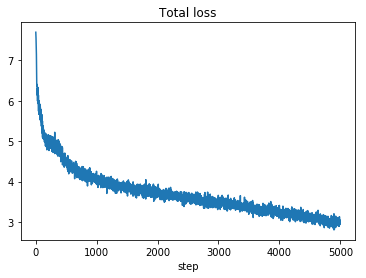

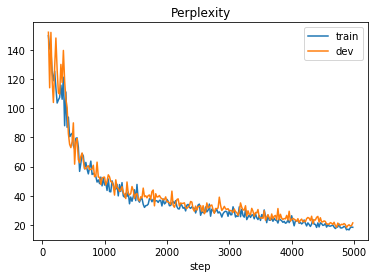

In [32]:
# plot loss
plt.figure()
plt.plot(losses)
plt.title("Total loss")
plt.xlabel("step")
plt.savefig(loss_fig)
plt.show()

# plot perplexity
plt.figure()
if len(perps) > len(steps):
    perps.pop()
plt.plot(steps[5:], perps[5:], label="train")
if dev_source_data is not None:
    plt.plot(steps[5:], dev_perps[5:], label="dev")
plt.title("Perplexity")
plt.xlabel("step")
plt.legend()
plt.savefig(perp_fig)
plt.show()

#### Check trained ECM model: internal memory and external choices

In [33]:
(cell, train_log_probs, alphas, int_M_emo) = train_outs

M_norms = sess.run(tf.norm(int_M_emo, axis=1), feed_dict)
print("Norms of final-state internal memory:\n", M_norms)

Norms of final-state internal memory:
 [2.8790933e-07 2.6792186e-06 2.4213847e-07 9.7954022e-08 8.2459685e-08
 3.9985258e-07 1.7050779e-07 2.7580190e-06 1.2004278e-06 2.8663001e-07
 4.3089946e-07 3.0665160e-07 4.6975921e-07 7.4334957e-07 7.0569762e-08
 3.1758930e-08 9.0873712e-08 3.5633196e-08 1.4215630e-07 1.0965078e-07
 4.3554115e-07 2.2078230e-07 2.2771822e-07 3.2793645e-07 5.5187702e-08
 2.7770790e-07 1.5649427e-07 1.7946068e-07 1.8988439e-07 6.8626349e-07
 7.8908255e-07 1.4694601e-07 1.0405934e-07 1.4652708e-06 9.5260850e-07
 4.2721987e-07 4.7273158e-08 5.9784895e-08 6.2863512e-07 2.7644569e-06
 4.9309651e-08 1.3292180e-07 1.1962375e-07 1.4266817e-07 5.7590989e-07
 5.3724852e-07 6.1734141e-08 1.7970169e-07 5.1682633e-07 5.6176653e-08
 5.7542120e-08 1.2704892e-07 1.1226833e-07 8.8842100e-08 2.3567678e-08
 9.0674877e-07 9.5734561e-07 2.5307341e-07 6.4216403e-07 7.8598937e-08
 1.0348766e-07 3.9680469e-07 4.9817862e-07 5.6060719e-07]


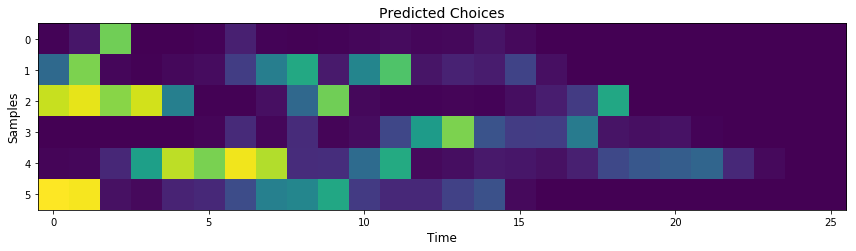

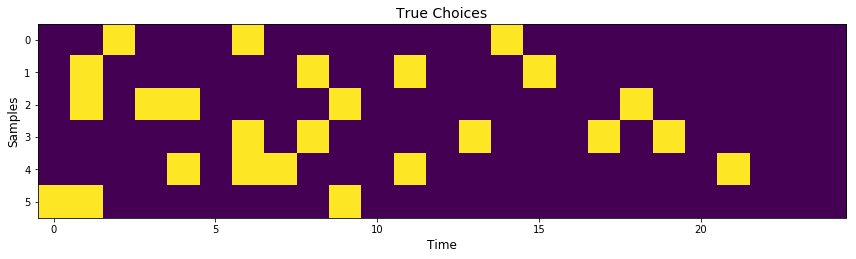

In [34]:
# alphas (predicted choice) and true choices
rand_indexes = np.random.choice(n_data, 6)
source_batch = source_data[rand_indexes]
target_batch = target_data[rand_indexes]
emotions = category_data[rand_indexes]

choice_preds = sess.run(alphas,
                        feed_dict={
                            source_ids: source_batch,
                            target_ids: target_batch,
                            emo_cat: emotions})
choice_batch = choice_data[rand_indexes]

plt.figure(figsize=(12, 4))
plt.imshow(choice_preds, interpolation="none")
plt.title("Predicted Choices", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()
plt.savefig("./predict_choice")

plt.figure(figsize=(12, 4))
plt.imshow(choice_batch, interpolation="none")
plt.title("True Choices", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()
plt.savefig("./true_choice")

### Inference

In [35]:
print("Loading inference data ...")

# id_0, id_1, id_2 preserved for SOS, EOS, constant zero padding
embed_shift = 3
filename = config["inference"]["infer_source_file"]
c_filename = config["inference"]["infer_category_file"]
max_leng = config["inference"]["infer_source_max_length"]

source_data = loadfile(filename, is_source=True,
                       max_length=max_leng) + embed_shift
category_data = pd.read_csv(
    c_filename, header=None, index_col=None, dtype=int)[0].values

print("\tDone.")

Loading inference data ...
	Done.


In [36]:
# Inference
print("Start inferring ...")
final_result = []
n_data = source_data.shape[0]
n_pad = n_data % infer_batch_size
if n_pad > 0:
    n_pad = infer_batch_size - n_pad

pad = np.zeros((n_pad, max_leng), dtype=np.int32)
source_data = np.concatenate((source_data, pad))
category_data = np.concatenate((category_data, np.zeros(n_pad)))

for ith in range(int(len(source_data) / infer_batch_size)):
    start = ith * infer_batch_size
    end = (ith + 1) * infer_batch_size
    batch = source_data[start:end]
    batch_cat = category_data[start:end]

    result = sess.run(infer_outputs,
                      feed_dict={source_ids: batch, emo_cat: batch_cat})
    result = result.ids[:, :, 0]

    if result.shape[1] < max_iter:
        l_pad = max_iter - result.shape[1]
        result = np.concatenate(
            (result, np.ones((infer_batch_size, l_pad))), axis=1)

    final_result.append(result)

final_result = np.concatenate(final_result)[:n_data] - embed_shift
choice_pred = (final_result >= vocab_size).astype(np.int)
final_result[final_result >= vocab_size] -= (vocab_size + embed_shift)

# transform to output format
final_result[final_result < 0] = -1
final_result = final_result.astype(str).tolist()
final_result = list(map(lambda t: " ".join(t), final_result))

choice_pred = choice_pred.astype(str).tolist()
choice_pred = list(map(lambda t: " ".join(t), choice_pred))

df = pd.DataFrame(data={"0": final_result})
df.to_csv(config["inference"]["output_path"], header=None, index=None)

cdf = pd.DataFrame(data={"0": choice_pred})
cdf.to_csv(config["inference"]["choice_path"], header=None, index=None)
print("\tDone.")

Start inferring ...
	Done.


### Evaluation

In [37]:
# perplexity
random_indexes = np.random.choice(len(dev_source_data), 256)
s = dev_source_data[random_indexes]
t = dev_target_data[random_indexes]
q = dev_choice_data[random_indexes]
c = dev_category_data[random_indexes]

m = (t != -1)

feed_dict = {
    source_ids: s,
    target_ids: t,
    choice_qs: q,
    emo_cat: c,
    sequence_mask: m,
}

compute_perplexity(sess, CE, m, feed_dict)

19.328549506730784